In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import swifter

import re
import statistics


INPUT_FOLDER = "physionet.org/files/"
DATA_FOLDER = "data/"

In [13]:
def basic_parse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Drop rows with missing values
    df = df.dropna()
    # Drop duplicate rows
    df = df.drop_duplicates(subset=["hadm_id", "icd_code"])
    return df


def parse_codes(df: pd.DataFrame) -> pd.DataFrame:
    # Split the icd_code into the first 3 characters and the rest
    df = df.dropna(subset=["icd_code"])
    df = df.drop_duplicates(subset=["hadm_id", "icd_code"])
    # Group by subject-id, hadm-id, and icd-version and aggregate the icd-codes into a list
    df = (
        df.groupby(["subject_id", "hadm_id", "icd_version"])
        .agg({"icd_code": list})
        .reset_index()
    )
    return df


def add_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """For each code in the icd_column, add a string prefix to the front followed by a hyphen.

    Codes are assumed to be strings.
    Returns the resulting dataframe."""
    df["icd_code"] = df["icd_code"].apply(lambda x: prefix + "-" + x)
    return df


def plot_top_n(df: pd.DataFrame, title: str, top_n: int, icd_version: int) -> None:
    """
    Plots the top n most frequent codes in a bar graph. Include the full name of the code hyphenated with the code.
    """
    df = df[df.icd_version == icd_version]
    # Get the top n most frequent codes
    top_codes = df.icd_code.value_counts().head(top_n)

    # Plot the graph
    top_codes.plot(kind="bar")
    plt.title(title)
    plt.show()


def extra_processing(text: str) -> str:
    # Remove fluff text such as "Date of Birth: ___", "Name: ___", "Unit No: ___"
    fluff_text = [
        "Date of Birth:",
        "Name:",
        "Unit No:",
        "Admission Date:",
        "Attending:",
        "Discharge Date:",
    ]
    for fluff in fluff_text:
        text = text.replace(fluff, "")

    # Strip

    text = re.sub(r"^[\s_]*", "", text)
    text = text.strip()
    return text

def prune_text(df: pd.DataFrame, max_len = 40000):
    # Remove entries that have text that includes more than max_tokens
    df = df[df.text.str.len() <= max_len]
    return df



In [14]:
diagnoses_icd = pd.read_csv(
    INPUT_FOLDER + "mimiciv/2.2/hosp/diagnoses_icd.csv.gz",
    compression="gzip",
)

procedures_icd = pd.read_csv(
    INPUT_FOLDER + "mimiciv/2.2/hosp/procedures_icd.csv.gz",
    compression="gzip",
)

# Remove all codes with less than 10 occurances
diagnoses_icd = diagnoses_icd.groupby("icd_code").filter(lambda x: len(x) > 10)
procedures_icd = procedures_icd.groupby("icd_code").filter(lambda x: len(x) > 10)

diagnoses_icd = basic_parse_dataframe(diagnoses_icd)
procedures_icd = basic_parse_dataframe(procedures_icd)

# Add the prefix to the icd_code
pre_diagnoses_icd = add_prefix(diagnoses_icd, "d")
pre_procedures_icd = add_prefix(procedures_icd, "p")

diagnoses_icd = parse_codes(pre_diagnoses_icd)
procedures_icd = parse_codes(pre_procedures_icd)

# Rename the icd_code column to icd_diag and icd_proc
diagnoses_icd = diagnoses_icd.rename(columns={"icd_code": "icd_diag"})
procedures_icd = procedures_icd.rename(columns={"icd_code": "icd_proc"})

In [15]:
# Split into ICD version 9 and version 10
diagnoses_icd9 = diagnoses_icd[diagnoses_icd.icd_version == 9]
diagnoses_icd10 = diagnoses_icd[diagnoses_icd.icd_version == 10]

procedures_icd9 = procedures_icd[procedures_icd.icd_version == 9]
procedures_icd10 = procedures_icd[procedures_icd.icd_version == 10]

In [16]:
diagnoses_icd9.head()

,subject_id,hadm_id,icd_version,icd_diag
0,10000032,22595853,9,"[d-5723, d-78959, d-5715, d-07070, d-496, d-29..."
1,10000032,22841357,9,"[d-07071, d-78959, d-2875, d-2761, d-496, d-57..."
2,10000032,25742920,9,"[d-07054, d-78959, d-V462, d-5715, d-2767, d-2..."
3,10000032,29079034,9,"[d-45829, d-07044, d-7994, d-2761, d-78959, d-..."
4,10000068,25022803,9,[d-30500]


In [17]:
procedures_icd10.head()

,subject_id,hadm_id,icd_version,icd_proc
4,10000117,27988844,10,[p-0QS734Z]
28,10001401,21544441,10,"[p-0TTB4ZZ, p-07BC4ZX, p-0UT9FZZ, p-0UTC7ZZ, p..."
29,10001401,26840593,10,"[p-02HV33Z, p-3E0436Z, p-0W9J30Z]"
30,10001401,27012892,10,[p-02HV33Z]
31,10001401,27060146,10,"[p-0D9W30Z, p-02HV33Z]"


In [18]:
# Get total label count. This is the number of diagnoses and procedure codes, seperated into icd9 and icd10

diagnoses_codes = pd.read_csv(
    INPUT_FOLDER + "mimiciv/2.2/hosp/d_icd_diagnoses.csv.gz",
    compression="gzip",
)

procedure_codes = pd.read_csv(
    INPUT_FOLDER + "mimiciv/2.2/hosp/d_icd_procedures.csv.gz",
    compression="gzip",
)

# Add the prefix to the icd_code
diagnoses_codes = add_prefix(diagnoses_codes, "d")
procedure_codes = add_prefix(procedure_codes, "p")

# Split into ICD version 9 and version 10
icd9_diagnoses_codes = diagnoses_codes[diagnoses_codes.icd_version == 9]
icd10_diagnoses_codes = diagnoses_codes[diagnoses_codes.icd_version == 10]

icd9_procedures_codes = procedure_codes[procedure_codes.icd_version == 9]
icd10_procedures_codes = procedure_codes[procedure_codes.icd_version == 10]

# Merge the diagnoses and procedures
icd9_codes = pd.concat([icd9_diagnoses_codes, icd9_procedures_codes])
icd10_codes = pd.concat([icd10_diagnoses_codes, icd10_procedures_codes])

# Print counts entries
print("ICD9 count:", len(icd9_codes))
print("ICD10 count:", len(icd10_codes))

ICD9 count: 18554
ICD10 count: 176478


In [19]:
# Print rows where hadm_id is "25022803"
diagnoses_icd9[diagnoses_icd9.hadm_id == 25022803]

,subject_id,hadm_id,icd_version,icd_diag
4,10000068,25022803,9,[d-30500]


In [20]:
icd9_codes.head()

,icd_code,icd_version,long_title
0,d-0010,9,Cholera due to vibrio cholerae
1,d-0011,9,Cholera due to vibrio cholerae el tor
2,d-0019,9,"Cholera, unspecified"
3,d-0020,9,Typhoid fever
4,d-0021,9,Paratyphoid fever A


In [21]:
mimic_notes = pd.read_csv(
    INPUT_FOLDER + "mimic-iv-note/2.2/note/discharge.csv.gz",
    compression="gzip",
    usecols=lambda x: x not in ["storetime", "note_type", "charttime"],
)
# Drop missing rows that are missing "text" or "hadm_id" or "subject_id"
mimic_notes = mimic_notes.dropna(subset=["text", "hadm_id", "subject_id"])

mimic_notes.head()

,note_id,subject_id,hadm_id,note_seq,text
0,10000032-DS-21,10000032,22595853,21,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,22,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,23,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,24,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,17,\nName: ___ Unit No: __...


In [22]:
# Apply extra processing to the text. Use swifter with dask
mimic_notes["text"] = mimic_notes["text"].swifter.apply(extra_processing)

# Get top 25 percentile text length
text_lengths = mimic_notes.text.str.len()


Pandas Apply: 100%|██████████| 331793/331793 [00:29<00:00, 11249.06it/s]


Mean text length: 10408.03212846564
Median text length: 9704
75th percentile text length: 12690.0


In [28]:
print("Mean text length:", statistics.mean(text_lengths))
print("Median text length:", statistics.median(text_lengths))
print("80th percentile text length:", np.percentile(text_lengths, 80))

Mean text length: 10408.03212846564
Median text length: 9704
75th percentile text length: 13535.0


In [29]:
# Prune text to remove entries that are too long
mimic_notes = prune_text(mimic_notes, max_len=np.percentile(text_lengths, 80))

In [30]:
mimic_9 = mimic_notes.merge(
    diagnoses_icd9[["hadm_id", "icd_diag"]], on="hadm_id", how="left"
)

mimic_9 = mimic_9.merge(
    procedures_icd9[["hadm_id", "icd_proc"]], on="hadm_id", how="left"
)

mimic_10 = mimic_notes.merge(
    diagnoses_icd10[["hadm_id", "icd_diag"]], on="hadm_id", how="left"
)

mimic_10 = mimic_10.merge(
    procedures_icd10[["hadm_id", "icd_proc"]], on="hadm_id", how="left"
)

# Remove notes with no icd code
mimic_9 = mimic_9.dropna(subset=["icd_diag", "icd_proc"])
mimic_10 = mimic_10.dropna(subset=["icd_diag", "icd_proc"])

mimic_9.head()

,note_id,subject_id,hadm_id,note_seq,text,icd_diag,icd_proc
0,10000032-DS-21,10000032,22595853,21,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-5723, d-78959, d-5715, d-07070, d-496, d-29...",[p-5491]
1,10000032-DS-22,10000032,22841357,22,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-07071, d-78959, d-2875, d-2761, d-496, d-57...",[p-5491]
3,10000032-DS-24,10000032,25742920,24,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-07054, d-78959, d-V462, d-5715, d-2767, d-2...",[p-5491]
8,10000560-DS-15,10000560,28979390,15,Sex: F\n \nService: UROLOGY\n \nAllergies: \...,"[d-1890, d-V1582, d-V1201]",[p-5551]
10,10000826-DS-17,10000826,20032235,17,. ___\n \n ___ __...,"[d-5712, d-486, d-78959, d-5723, d-5990, d-263...",[p-5491]


In [32]:
# Create label column
mimic_9["label"] = mimic_9["icd_diag"] + mimic_9["icd_proc"]
mimic_10["label"] = mimic_10["icd_diag"] + mimic_10["icd_proc"]

mimic_9.head()

,note_id,subject_id,hadm_id,note_seq,text,icd_diag,icd_proc,label
0,10000032-DS-21,10000032,22595853,21,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-5723, d-78959, d-5715, d-07070, d-496, d-29...",[p-5491],"[d-5723, d-78959, d-5715, d-07070, d-496, d-29..."
1,10000032-DS-22,10000032,22841357,22,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-07071, d-78959, d-2875, d-2761, d-496, d-57...",[p-5491],"[d-07071, d-78959, d-2875, d-2761, d-496, d-57..."
3,10000032-DS-24,10000032,25742920,24,Sex: F\n \nService: MEDICINE\n \nAllergies: ...,"[d-07054, d-78959, d-V462, d-5715, d-2767, d-2...",[p-5491],"[d-07054, d-78959, d-V462, d-5715, d-2767, d-2..."
8,10000560-DS-15,10000560,28979390,15,Sex: F\n \nService: UROLOGY\n \nAllergies: \...,"[d-1890, d-V1582, d-V1201]",[p-5551],"[d-1890, d-V1582, d-V1201, p-5551]"
10,10000826-DS-17,10000826,20032235,17,. ___\n \n ___ __...,"[d-5712, d-486, d-78959, d-5723, d-5990, d-263...",[p-5491],"[d-5712, d-486, d-78959, d-5723, d-5990, d-263..."


In [33]:
# Check for codes shared between icd9 diagnoses and procedures
shared_codes_9 = set(icd9_diagnoses_codes.icd_code).intersection(
    set(icd9_procedures_codes.icd_code)
)
print("Shared codes:", len(shared_codes_9))

# Check for codes shared between icd10 diagnoses and procedures
shared_codes_10 = set(icd10_diagnoses_codes.icd_code).intersection(
    set(icd10_procedures_codes.icd_code)
)

print("Shared codes:", len(shared_codes_10))

Shared codes: 0
Shared codes: 0


In [34]:
# Report the number of entries, the average length of labels, average length of text, and the number of labels that occur more than 5 times

print("MIMIC-9")
print("Number of entries:", len(mimic_9))
print("Average length of labels:", np.mean(mimic_9.label.apply(len)))
print("Average length of text:", np.mean(mimic_9.text.apply(len)))

print("MIMIC-10")
print("Number of entries:", len(mimic_10))
print("Average length of labels:", np.mean(mimic_10.label.apply(len)))
print("Average length of text:", np.mean(mimic_10.text.apply(len)))

MIMIC-9
Number of entries: 103552
Average length of labels: 13.268068216934488
Average length of text: 8243.569742737947
MIMIC-10
Number of entries: 44985
Average length of labels: 15.234744914971657
Average length of text: 9266.974547071246


In [35]:
# Concat pre diag and pre_proc
mimic = pd.concat([pre_diagnoses_icd, pre_procedures_icd])

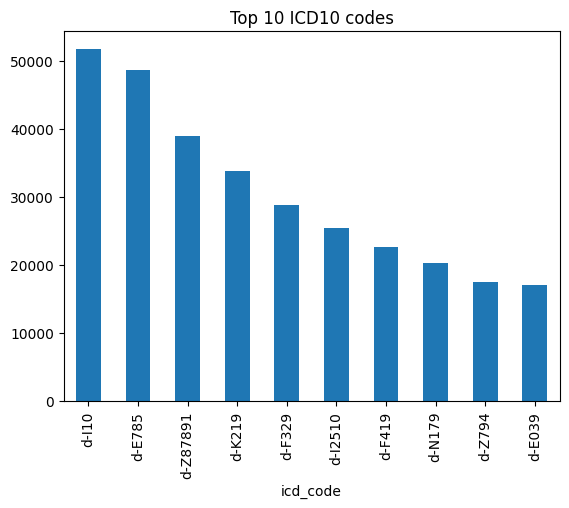

In [36]:
plot_top_n(mimic, "Top 10 ICD10 codes", 10, 10)

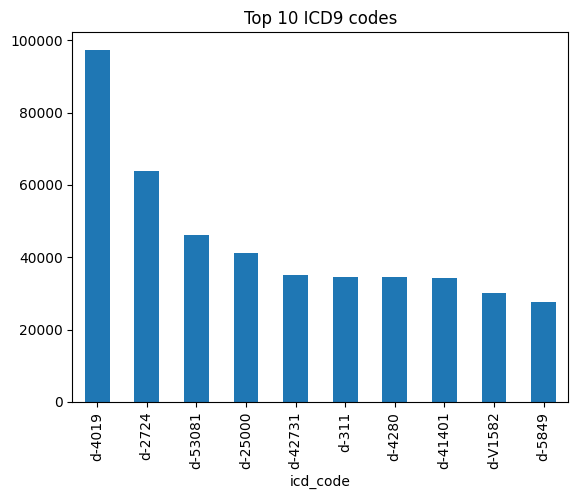

In [37]:
plot_top_n(mimic, "Top 10 ICD9 codes", 10, 9)

In [38]:
# Cleanup

# Drop all columns other than text and label
mimic_9 = mimic_9[["text", "label"]]
mimic_10 = mimic_10[["text", "label"]]

In [39]:
# Split into training, validation, and test sets
train_9 = mimic_9.sample(frac=0.8, random_state=0)
test_9 = mimic_9.drop(train_9.index)
val_9 = test_9.sample(frac=0.5, random_state=0)
test_9 = test_9.drop(val_9.index)

train_10 = mimic_10.sample(frac=0.8, random_state=0)
test_10 = mimic_10.drop(train_10.index)
val_10 = test_10.sample(frac=0.5, random_state=0)
test_10 = test_10.drop(val_10.index)

In [40]:
# Save dataset to disk
train_9.to_csv(DATA_FOLDER + "train_9.csv", index=False)
val_9.to_csv(DATA_FOLDER + "val_9.csv", index=False)
test_9.to_csv(DATA_FOLDER + "test_9.csv", index=False)

train_10.to_csv(DATA_FOLDER + "train_10.csv", index=False)
val_10.to_csv(DATA_FOLDER + "val_10.csv", index=False)
test_10.to_csv(DATA_FOLDER + "test_10.csv", index=False)

# Code list
icd9_codes.to_csv(DATA_FOLDER + "icd9_codes.csv", index=False)
icd10_codes.to_csv(DATA_FOLDER + "icd10_codes.csv", index=False)